<a href="https://colab.research.google.com/github/melilucmel/DSIICorder_Proyecto_Final_Notebook/blob/main/DSII_Proyecto_Final_Criptomonedas_ML_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoderHouse DSII - Proyecto Final: *"Análisis exploratorio de criptomonedas para un exchange minorista"*

## I. Abstract – Motivación y audiencia

En este proyecto realizo un **análisis exploratorio de datos (EDA)** sobre **precios y volúmenes** de distintas criptomonedas obtenidos desde una **API pública (CoinGecko)**.

- **Motivación:** entender el comportamiento reciente del mercado cripto (volatilidad, tendencias de precio y volumen operado) para apoyar decisiones de negocio en un *exchange minorista* (por ejemplo: qué activos listar, priorizar o destacar en la app).
- **Audiencia:** equipo ejecutivo + analistas de negocio / producto / marketing que necesitan una visión clara y visual, sin entrar en detalles complejos.

---

## II. Preguntas e hipótesis

Preguntas que busco responder con los datos:

1. ¿Cuáles son las criptomonedas con mayor **volumen promedio** en el período analizado?
2. ¿Qué monedas presentan mayor **volatilidad** de precio (en retornos diarios)?
3. ¿Existen patrones de **correlación** entre las variaciones de precio de las principales criptomonedas?
4. ¿Cómo se comportó el precio de **Bitcoin** frente a otras altcoins en el tiempo?
5. ¿Qué activos podrían considerarse más **"estables"** dentro del universo analizado?

Hipótesis de trabajo:

- H1: Bitcoin y Ethereum presentan los mayores volúmenes de operación promedio.
- H2: Algunas altcoins presentan volatilidad significativamente superior a Bitcoin.
- H3: Existe alta correlación entre las variaciones diarias de Bitcoin y Ethereum.

---

## III. Problema de Machine Learning (Regresión)

**Objetivo:** predecir el **retorno porcentual del día siguiente** (*t+1*) para las criptomonedas seleccionadas.

**Por qué no predigo el precio directo:** porque el precio cambia muchísimo entre activos (BTC vs altcoins). En cambio, el retorno:
- hace comparables activos de distinta escala,
- reduce problemas de escala,
- suele ser más estable estadísticamente.

**Target (y):** retorno porcentual del día siguiente (t+1).  
**Features (X):** variables derivadas de precio y volumen (lags, medias móviles, volatilidad rolling, momentum, etc.).

> Nota: mantengo toda la parte de EDA como base (primera entrega) y agrego la parte de ML al final, como continuidad del proyecto.


In [1]:
# 1. Importación de librerías

import time
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("whitegrid")


In [2]:
# 2. Definición de parámetros (criptomonedas y ventana temporal)

# IDs usados por CoinGecko
coins = ["bitcoin", "ethereum", "solana", "cardano", "ripple"]

vs_currency = "usd"
days = 90  # historial hacia atrás

print("Criptomonedas seleccionadas:", coins)
print("Moneda base:", vs_currency)
print("Días de historial:", days)


Criptomonedas seleccionadas: ['bitcoin', 'ethereum', 'solana', 'cardano', 'ripple']
Moneda base: usd
Días de historial: 90


### 2a. Llamada a API de CoinGecko

- **coin_id:** ID de la cripto (ej: `"bitcoin"`)
- **vs_currency:** moneda base (ej: `"usd"`)
- **days:** días hacia atrás (ej: `90`)

La API devuelve listas de pares `[timestamp, value]` para precios y volúmenes.


In [3]:
# Función para descargar histórico de precios y volúmenes desde CoinGecko
# Devuelve DataFrame con columnas: timestamp, date, coin, price, volume

def get_coin_history(coin_id, vs_currency="usd", days=90):
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {"vs_currency": vs_currency, "days": days}

    response = requests.get(url, params=params)
    response.raise_for_status()

    data = response.json()
    prices = data["prices"]
    volumes = data["total_volumes"]

    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["volume"] = [v[1] for v in volumes]
    df["coin"] = coin_id
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df["date"] = df["timestamp"].dt.date

    return df


### 3. Obtención de datos y creación de CSV

In [4]:
# Descargo los datos de todas las criptos y guardo un CSV local (reproducible)
dfs = []

for c in coins:
    print(f"Descargando datos de: {c}...")
    try:
        df_c = get_coin_history(c, vs_currency=vs_currency, days=days)
        dfs.append(df_c)
        time.sleep(1)  # pausa para no bombardear la API
    except Exception as e:
        print(f"⚠️ Error descargando {c}: {e}")

df_crypto = pd.concat(dfs, ignore_index=True)
print("Dimensión del DataFrame combinado:", df_crypto.shape)

csv_filename = "crypto_history_90d.csv"
df_crypto.to_csv(csv_filename, index=False)
print(f"Archivo guardado como: {csv_filename}")


Descargando datos de: bitcoin...
Descargando datos de: ethereum...
Descargando datos de: solana...
Descargando datos de: cardano...
Descargando datos de: ripple...
Dimensión del DataFrame combinado: (10804, 5)
Archivo guardado como: crypto_history_90d.csv


### 3a. Carga y chequeo de CSV

In [5]:
# Cargo los datos desde el CSV guardado
df = pd.read_csv("crypto_history_90d.csv", parse_dates=["timestamp"])
df.head()


,timestamp,price,volume,coin,date
0,2025-11-02 23:01:24.645,109715.864303,3.417452e+10,bitcoin,2025-11-02
1,2025-11-03 00:01:44.627,110650.209282,3.509877e+10,bitcoin,2025-11-03
2,2025-11-03 01:01:14.193,110018.317868,3.655110e+10,bitcoin,2025-11-03
3,2025-11-03 02:01:27.898,109635.308404,3.858163e+10,bitcoin,2025-11-03
4,2025-11-03 03:02:01.852,108986.501389,4.082265e+10,bitcoin,2025-11-03


## 4. Exploración de Dataset (EDA)

In [6]:
# Resumen básico del DataFrame

print("Shape (filas, columnas):", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

print("\nPrimeras filas:")
display(df.head())

print("\nDescripción estadística:")
display(df.describe())


Shape (filas, columnas): (10804, 5)

Tipos de datos:
timestamp    datetime64[ns]
price               float64
volume              float64
coin                 object
date                 object
dtype: object

Primeras filas:


,timestamp,price,volume,coin,date
0,2025-11-02 23:01:24.645,109715.864303,3.417452e+10,bitcoin,2025-11-02
1,2025-11-03 00:01:44.627,110650.209282,3.509877e+10,bitcoin,2025-11-03
2,2025-11-03 01:01:14.193,110018.317868,3.655110e+10,bitcoin,2025-11-03
3,2025-11-03 02:01:27.898,109635.308404,3.858163e+10,bitcoin,2025-11-03
4,2025-11-03 03:02:01.852,108986.501389,4.082265e+10,bitcoin,2025-11-03



Descripción estadística:


,timestamp,price,volume
count,10804,10804.000000,1.080400e+04
mean,2025-12-17 22:57:09.965807104,18966.709828,1.795567e+10
min,2025-11-02 23:01:24.645000,0.283897,1.891607e+08
25%,2025-11-25 11:04:05.258500096,1.912604,2.136410e+09
50%,2025-12-17 23:02:06.447500032,133.892125,5.630421e+09
75%,2026-01-09 11:01:18.866249984,3197.359140,2.834096e+10
max,2026-01-31 22:42:33,110650.209282,1.481363e+11
std,NaN,36419.071567,2.350283e+10


### 4a. Revisión de faltantes / duplicados

In [7]:
# Porcentaje de valores faltantes por columna
display(df.isna().mean().sort_values(ascending=False))

# Cantidad de filas duplicadas
print("Duplicados:", df.duplicated().sum())


,0
timestamp,0.0
price,0.0
volume,0.0
coin,0.0
date,0.0


Duplicados: 0


### 4b. Estado actual de precios (último día)

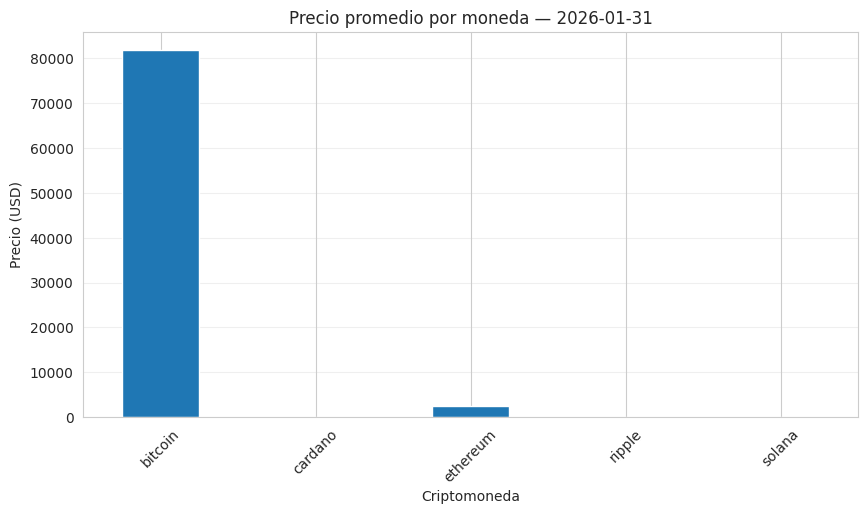

In [8]:
latest_date = df["date"].max()
df_latest = df[df["date"] == str(latest_date)]

plt.figure(figsize=(10,5))
df_latest.groupby("coin")["price"].mean().plot(kind="bar")
plt.title(f"Precio promedio por moneda — {latest_date}")
plt.ylabel("Precio (USD)")
plt.xlabel("Criptomoneda")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()


### 4c. Volumen promedio por moneda (univariado)

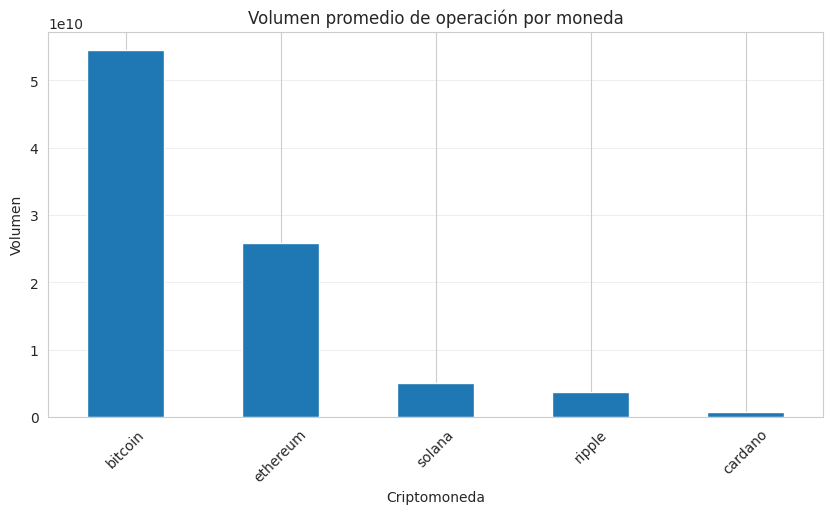

In [9]:
plt.figure(figsize=(10,5))
df.groupby("coin")["volume"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Volumen promedio de operación por moneda")
plt.ylabel("Volumen")
plt.xlabel("Criptomoneda")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()


### 4d. Boxplot de precios (volatilidad visual)

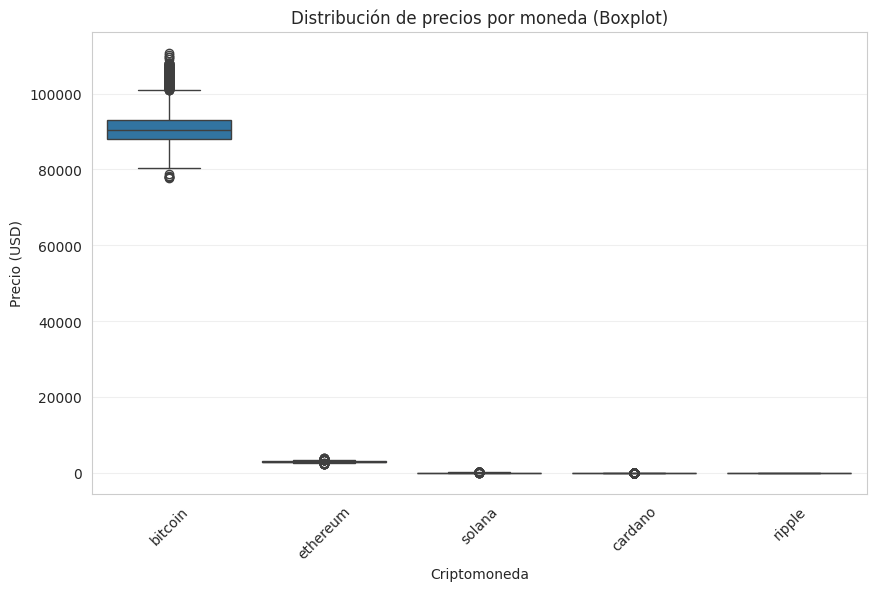

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="coin", y="price")
plt.title("Distribución de precios por moneda (Boxplot)")
plt.xlabel("Criptomoneda")
plt.ylabel("Precio (USD)")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()


### 4e. Evolución temporal del precio por moneda

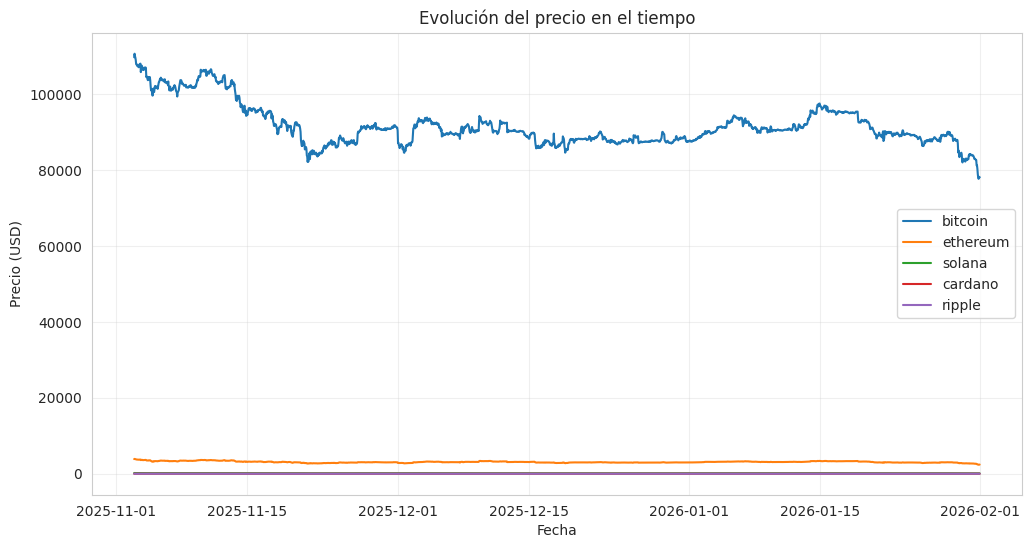

In [11]:
plt.figure(figsize=(12,6))

for c in df["coin"].unique():
    subset = df[df["coin"] == c]
    plt.plot(subset["timestamp"], subset["price"], label=c)

plt.title("Evolución del precio en el tiempo")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 5. EDA multivariado

In [12]:
# Calculo retornos diarios por moneda
df_sorted = df.sort_values(["coin", "timestamp"]).copy()
df_sorted["return"] = df_sorted.groupby("coin")["price"].pct_change()
df_sorted.head()


,timestamp,price,volume,coin,date,return
0,2025-11-02 23:01:24.645,109715.864303,3.417452e+10,bitcoin,2025-11-02,NaN
1,2025-11-03 00:01:44.627,110650.209282,3.509877e+10,bitcoin,2025-11-03,0.008516
2,2025-11-03 01:01:14.193,110018.317868,3.655110e+10,bitcoin,2025-11-03,-0.005711
3,2025-11-03 02:01:27.898,109635.308404,3.858163e+10,bitcoin,2025-11-03,-0.003481
4,2025-11-03 03:02:01.852,108986.501389,4.082265e+10,bitcoin,2025-11-03,-0.005918


In [13]:
# Tabla pivote: monedas en columnas, retornos en filas
returns_pivot = df_sorted.pivot_table(index="timestamp", columns="coin", values="return")
returns_pivot.tail()


coin,bitcoin,cardano,ethereum,ripple,solana
timestamp,,,,,
2026-01-31 22:41:24,-0.001689,NaN,NaN,NaN,NaN
2026-01-31 22:42:13,NaN,-0.008898,NaN,NaN,NaN
2026-01-31 22:42:23,NaN,NaN,NaN,NaN,0.003516
2026-01-31 22:42:26,NaN,NaN,-0.000787,NaN,NaN
2026-01-31 22:42:33,NaN,NaN,NaN,-0.007601,NaN


coin,bitcoin,cardano,ethereum,ripple,solana
coin,,,,,
bitcoin,1.0,NaN,NaN,NaN,NaN
cardano,NaN,1.0,NaN,NaN,NaN
ethereum,NaN,NaN,1.0,NaN,NaN
ripple,NaN,NaN,NaN,1.0,NaN
solana,NaN,NaN,NaN,NaN,1.0


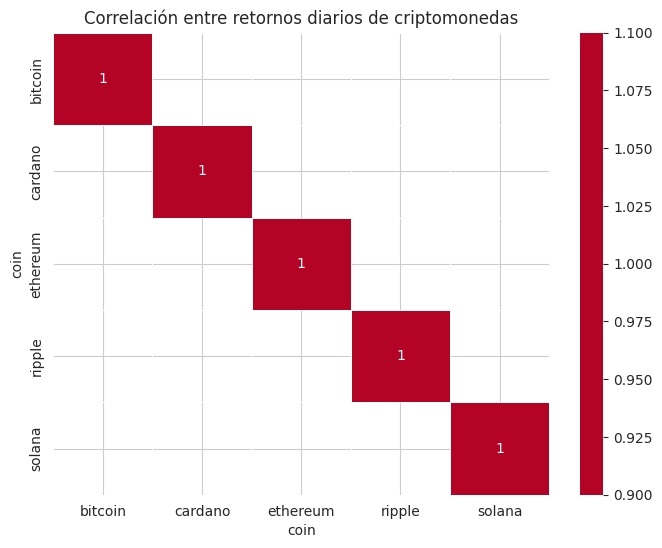

In [14]:
# Matriz de correlación
corr = returns_pivot.corr()
display(corr)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Correlación entre retornos diarios de criptomonedas")
plt.show()


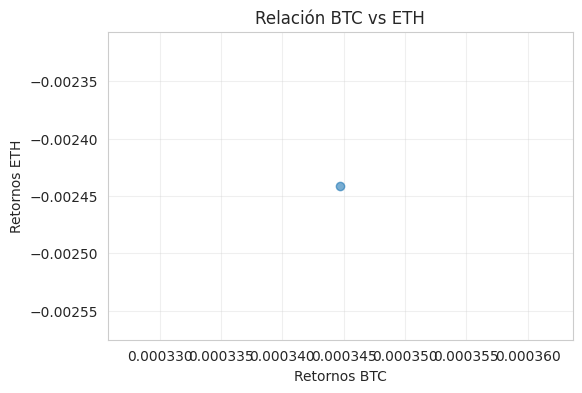

In [15]:
# Dispersión BTC vs ETH
plt.figure(figsize=(6,4))
plt.scatter(returns_pivot["bitcoin"], returns_pivot["ethereum"], alpha=0.6)
plt.xlabel("Retornos BTC")
plt.ylabel("Retornos ETH")
plt.title("Relación BTC vs ETH")
plt.grid(alpha=0.3)
plt.show()


,return
coin,
cardano,0.008462
solana,0.007663
ripple,0.007131
ethereum,0.006956
bitcoin,0.004758


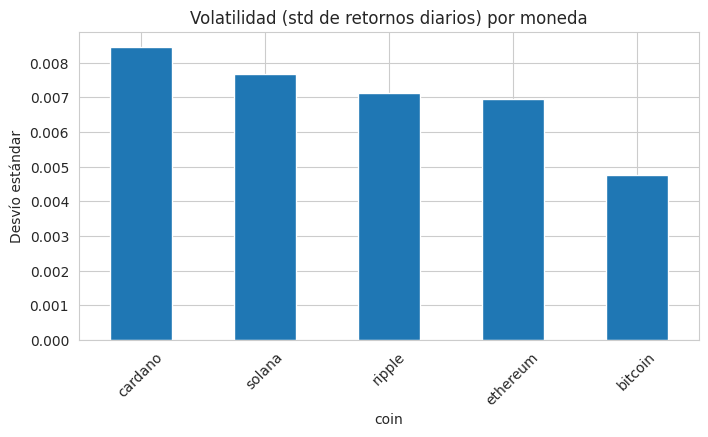

In [16]:
# Ranking de volatilidad real (std de retornos diarios)
volatility = df_sorted.groupby("coin")["return"].std().sort_values(ascending=False)
display(volatility)

plt.figure(figsize=(8,4))
volatility.plot(kind="bar")
plt.title("Volatilidad (std de retornos diarios) por moneda")
plt.ylabel("Desvío estándar")
plt.xticks(rotation=45)
plt.show()


## 6. Insights preliminares (EDA)

1. **Precios:** Bitcoin se destaca con un precio promedio muy superior. Ethereum ocupa el segundo lugar, y las altcoins (Solana, Cardano, Ripple) quedan muy por debajo. Esta diferencia de escala explica la desproporción en gráficos.
2. **Volumen:** Bitcoin y Ethereum concentran los volúmenes promedio más altos. Solana, Ripple y Cardano muestran menor actividad y liquidez.
3. **Volatilidad:** las altcoins tienen mayor volatilidad relativa (en retornos) que BTC/ETH → mayor riesgo.
4. **Correlación:** BTC y ETH tienen correlación positiva alta. Varias altcoins muestran correlaciones moderadas → potencial diversificación.
5. **Evolución temporal:** BTC muestra ciclos de suba y corrección. ETH acompaña parcialmente los movimientos.

---

## 7. Conclusiones (EDA)

El análisis exploratorio de Bitcoin, Ethereum, Solana, Cardano y Ripple me permitió entender diferencias claras en **precio, volumen, volatilidad y correlaciones**.

- Para un exchange minorista, BTC y ETH suelen ser prioritarios por su **liquidez**.
- Las altcoins pueden atraer traders por mayor volatilidad, pero exigen gestión de riesgo y comunicación clara.
- Analizar retornos en lugar de precio absoluto permite comparaciones más justas entre activos.

---

# IV. Machine Learning – Entrenamiento y optimización (Entrega Final)

A continuación agrego la parte de Machine Learning como continuidad del trabajo:

1) **Ingeniería de atributos** (features nuevas, con justificación).  
2) **Definición del dataset de ML** (X e y).  
3) **Entrenamiento y testeo** de al menos 2 modelos, con **validación cruzada**.  
4) **Optimización** de hiperparámetros.  
5) **Selección del mejor modelo** con métricas (RMSE, MAE, R²).  
6) **Visualizaciones** de evaluación (pred vs real, residuales, importancia de variables, comparación de modelos).


In [17]:
# 1) Librerías de ML

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 8. Feature engineering (creación de variables)

Parto de un dataset "largo" (cada fila es una moneda en un timestamp). Para poder hacer regresión sobre retornos:

- **Target:** `return_t+1` (retorno del próximo día) por moneda.
- **Features:** lags de retornos, rolling de volatilidad, rolling de volumen, momentum simple, etc.

> Importante: creo features *por moneda* (groupby coin) para evitar mezclar escalas.


In [18]:
# Construyo dataset para ML
data_ml = df.sort_values(["coin", "timestamp"]).copy()

# Retorno diario (ya estaba en df_sorted, pero lo recalculo acá para tenerlo junto)
data_ml["return"] = data_ml.groupby("coin")["price"].pct_change()

# Target: retorno del día siguiente
data_ml["target_return_next"] = data_ml.groupby("coin")["return"].shift(-1)

# Features: lags de retornos (memoria de corto plazo)
for lag in [1, 2, 3, 7]:
    data_ml[f"ret_lag_{lag}"] = data_ml.groupby("coin")["return"].shift(lag)

# Features: rolling stats de retornos (volatilidad y tendencia)
for w in [3, 7, 14]:
    data_ml[f"ret_roll_mean_{w}"] = data_ml.groupby("coin")["return"].shift(1).rolling(w).mean()
    data_ml[f"ret_roll_std_{w}"] = data_ml.groupby("coin")["return"].shift(1).rolling(w).std()

# Features: rolling stats de volumen (actividad / liquidez)
for w in [3, 7, 14]:
    data_ml[f"vol_roll_mean_{w}"] = data_ml.groupby("coin")["volume"].shift(1).rolling(w).mean()
    data_ml[f"vol_roll_std_{w}"] = data_ml.groupby("coin")["volume"].shift(1).rolling(w).std()

# Momentum simple: retorno acumulado en ventana
for w in [3, 7, 14]:
    data_ml[f"momentum_{w}"] = data_ml.groupby("coin")["return"].shift(1).rolling(w).sum()

# Limpieza: me quedo con filas donde ya tengo suficientes datos para features + target
data_ml = data_ml.dropna().reset_index(drop=True)

print("Dataset para ML:", data_ml.shape)
data_ml.head()


Dataset para ML: (10724, 26)


,timestamp,price,volume,coin,date,return,target_return_next,ret_lag_1,ret_lag_2,ret_lag_3,...,ret_roll_std_14,vol_roll_mean_3,vol_roll_std_3,vol_roll_mean_7,vol_roll_std_7,vol_roll_mean_14,vol_roll_std_14,momentum_3,momentum_7,momentum_14
0,2025-11-03 14:01:59.347,107993.558394,4.898340e+10,bitcoin,2025-11-03,0.001618,0.000339,0.000376,0.005192,0.001154,...,0.004604,4.781758e+10,6.725333e+08,4.663683e+10,1.333301e+09,4.354084e+10,4.214497e+09,0.006722,0.002321,-0.017291
1,2025-11-03 15:01:14.313,108030.115488,5.042864e+10,bitcoin,2025-11-03,0.000339,-0.020622,0.001618,0.000376,0.005192,...,0.003775,4.844505e+10,5.334185e+08,4.720212e+10,1.374902e+09,4.453259e+10,3.674116e+09,0.007187,0.005337,-0.024188
2,2025-11-03 16:00:35.420,105802.323890,5.683415e+10,bitcoin,2025-11-03,-0.020622,0.007308,0.000339,0.001618,0.000376,...,0.003627,4.928237e+10,1.029872e+09,4.787874e+10,1.646637e+09,4.552385e+10,3.196051e+09,0.002333,0.004631,-0.018139
3,2025-11-03 17:02:30.929,106575.486921,6.241378e+10,bitcoin,2025-11-03,0.007308,0.008833,-0.020622,0.000339,0.001618,...,0.006317,5.208207e+10,4.178389e+09,4.953403e+10,3.424476e+09,4.682760e+10,3.810143e+09,-0.018665,-0.015544,-0.035280
4,2025-11-03 18:07:39.623,107516.838811,6.618836e+10,bitcoin,2025-11-03,0.008833,-0.004899,0.007308,-0.020622,0.000339,...,0.006745,5.655886e+10,5.997307e+09,5.173039e+10,5.719243e+09,4.836982e+10,5.279092e+09,-0.012976,-0.004636,-0.022054


### ¿Por qué estas features?

- **Lags de retornos:** capturan autocorrelación de corto plazo (si existiera).
- **Rolling mean / std:** aproximan tendencia y volatilidad reciente.
- **Volumen rolling:** aproxima cambios de actividad y liquidez.
- **Momentum:** resume dirección (subas/bajas) en ventana corta.

Esto responde directo a la corrección del tutor: **agregar variables** y **documentar por qué** las creo.


## 9. Dataset final (X, y) + split temporal

In [19]:
# Variables para el modelo
target = "target_return_next"

feature_cols = [
    "coin",
    "ret_lag_1","ret_lag_2","ret_lag_3","ret_lag_7",
    "ret_roll_mean_3","ret_roll_mean_7","ret_roll_mean_14",
    "ret_roll_std_3","ret_roll_std_7","ret_roll_std_14",
    "vol_roll_mean_3","vol_roll_mean_7","vol_roll_mean_14",
    "vol_roll_std_3","vol_roll_std_7","vol_roll_std_14",
    "momentum_3","momentum_7","momentum_14"
]

X = data_ml[feature_cols].copy()
y = data_ml[target].copy()

# Split temporal para evitar leakage: entreno con el tramo inicial y testeo con el tramo final
# (como es un problema tipo serie temporal, esto es más realista)
data_ml_sorted_time = data_ml.sort_values("timestamp").reset_index(drop=True)
X = data_ml_sorted_time[feature_cols].copy()
y = data_ml_sorted_time[target].copy()

split_idx = int(len(data_ml_sorted_time) * 0.75)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Rango train:", data_ml_sorted_time.loc[0, "timestamp"], "->", data_ml_sorted_time.loc[split_idx-1, "timestamp"])
print("Rango test :", data_ml_sorted_time.loc[split_idx, "timestamp"], "->", data_ml_sorted_time.loc[len(data_ml_sorted_time)-1, "timestamp"])


Train: (8043, 20) Test: (2681, 20)
Rango train: 2025-11-03 14:01:27.042000 -> 2026-01-09 14:01:05.051000
Rango test : 2026-01-09 14:01:05.218000 -> 2026-01-31 22:02:36.309000


## 10. Pipelines + validación cruzada

In [20]:
# Preprocesamiento:
# - 'coin' es categórica -> OneHot
# - numéricas -> StandardScaler (para modelos lineales)
categorical_features = ["coin"]
numeric_features = [c for c in feature_cols if c != "coin"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="drop"
)

# Modelos (al menos 2)
model_ridge = Ridge(random_state=42)
model_rf = RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1)
model_gb = GradientBoostingRegressor(random_state=42)

pipe_ridge = Pipeline(steps=[("prep", preprocess), ("model", model_ridge)])
pipe_rf = Pipeline(steps=[("prep", preprocess), ("model", model_rf)])
pipe_gb = Pipeline(steps=[("prep", preprocess), ("model", model_gb)])

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

def cv_rmse(pipe, X_tr, y_tr, cv):
    rmses = []
    for tr_idx, val_idx in cv.split(X_tr):
        X_tr_fold, X_val_fold = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
        y_tr_fold, y_val_fold = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]

        pipe.fit(X_tr_fold, y_tr_fold)
        pred = pipe.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, pred))  # sin squared=...
        rmses.append(rmse)
    return np.mean(rmses), np.std(rmses)

for name, pipe in [("Ridge", pipe_ridge), ("RandomForest", pipe_rf), ("GradientBoosting", pipe_gb)]:
    mean_rmse, std_rmse = cv_rmse(pipe, X_train, y_train, tscv)
    print(f"{name:>15} | CV RMSE = {mean_rmse:.6f} ± {std_rmse:.6f}")


          Ridge | CV RMSE = 0.006859 ± 0.001240
   RandomForest | CV RMSE = 0.007114 ± 0.001229
GradientBoosting | CV RMSE = 0.007042 ± 0.001264


## 11. Entrenamiento final + evaluación en test

In [21]:
# Entreno en train completo y evalúo en test
def evaluate(pipe, X_tr, y_tr, X_te, y_te, label="model"):
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)

    rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae = mean_absolute_error(y_te, pred)
    r2 = r2_score(y_te, pred)

    return {"model": label, "rmse": rmse, "mae": mae, "r2": r2, "pred": pred}

res_ridge = evaluate(pipe_ridge, X_train, y_train, X_test, y_test, "Ridge")
res_rf    = evaluate(pipe_rf, X_train, y_train, X_test, y_test, "RandomForest")
res_gb    = evaluate(pipe_gb, X_train, y_train, X_test, y_test, "GradientBoosting")

results_df = pd.DataFrame([
    {k:v for k,v in res_ridge.items() if k!="pred"},
    {k:v for k,v in res_rf.items() if k!="pred"},
    {k:v for k,v in res_gb.items() if k!="pred"},
]).sort_values("rmse")

display(results_df)


,model,rmse,mae,r2
0,Ridge,0.006325,0.003974,-0.011207
2,GradientBoosting,0.006371,0.004039,-0.026073
1,RandomForest,0.006528,0.004169,-0.077152


## 12. Optimización de hiperparámetros (RandomizedSearchCV)

In [26]:
# Hiperparámetros a explorar (RandomForest)
param_dist = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 4],
    "model__max_features": ["sqrt"],
}

search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist,
    n_iter=3,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

X_tune = X_train.sample(frac=0.5, random_state=42)
y_tune = y_train.loc[X_tune.index]
search.fit(X_tune, y_tune)

print("Mejores hiperparámetros:", search.best_params_)
print("Mejor CV RMSE:", -search.best_score_)


Mejores hiperparámetros: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': None}
Mejor CV RMSE: 0.007205286132838688


In [27]:
# Evaluación del mejor modelo en test
best_rf = search.best_estimator_

best_res = evaluate(best_rf, X_train, y_train, X_test, y_test, "RandomForest (tuned)")
best_row = {k:v for k,v in best_res.items() if k!="pred"}

display(pd.DataFrame([best_row]))


,model,rmse,mae,r2
0,RandomForest (tuned),0.006398,0.004057,-0.034787


## 13. Visualizaciones de evaluación

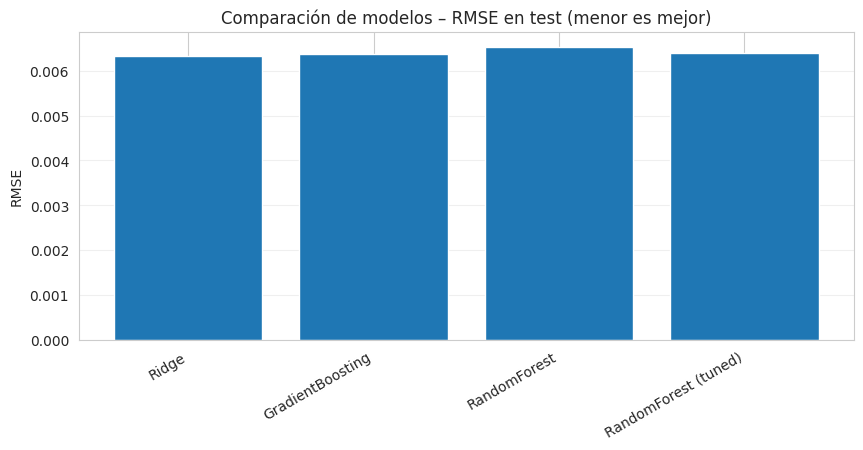

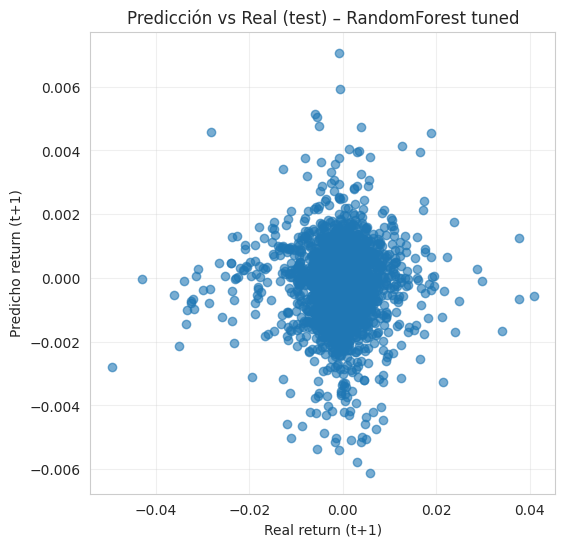

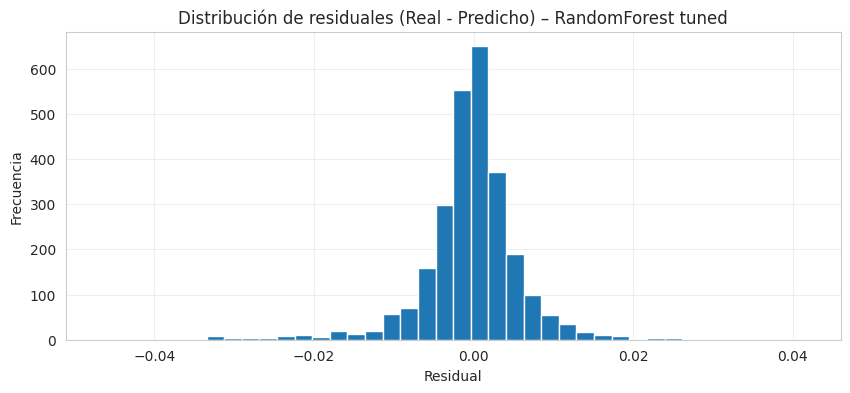

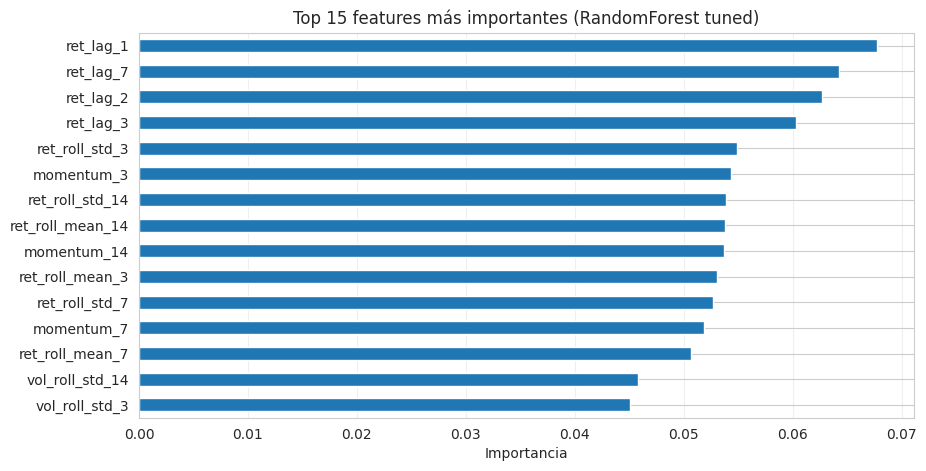

In [30]:
# 13a) Comparación de modelos (RMSE en test)
plot_df = pd.concat([
    results_df,
    pd.DataFrame([best_row])
], ignore_index=True)

plt.figure(figsize=(10,4))
plt.bar(plot_df["model"], plot_df["rmse"])
plt.title("Comparación de modelos – RMSE en test (menor es mejor)")
plt.ylabel("RMSE")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.show()

# 13b) Predicción vs Real (mejor modelo)
best_pred = best_res["pred"]

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.title("Predicción vs Real (test) – RandomForest tuned")
plt.xlabel("Real return (t+1)")
plt.ylabel("Predicho return (t+1)")
plt.grid(alpha=0.3)
plt.show()

# 13c) Residuales (histograma)
residuals = y_test - best_pred
plt.figure(figsize=(10,4))
plt.hist(residuals, bins=40)
plt.title("Distribución de residuales (Real - Predicho) – RandomForest tuned")
plt.xlabel("Residual")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

# 13d) Importancia de variables (aprox) desde el RandomForest entrenado
# (tomo el estimador final y nombres de features del preprocesamiento)
rf_est = best_rf.named_steps["model"]
ohe = best_rf.named_steps["prep"].named_transformers_["cat"]
coin_ohe_names = list(ohe.get_feature_names_out(["coin"]))
all_feature_names = coin_ohe_names + numeric_features

importances = pd.Series(rf_est.feature_importances_, index=all_feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(10,5))
importances.sort_values().plot(kind="barh")
plt.title("Top 15 features más importantes (RandomForest tuned)")
plt.xlabel("Importancia")
plt.grid(axis="x", alpha=0.3)
plt.show()

## 14. Conclusiones (ML)

- Con ingeniería de atributos (lags, rolling stats, momentum y volumen), pude construir un dataset más rico para modelar retornos.
- Entrené y comparé **al menos 2 modelos** (Ridge, RandomForest, GradientBoosting) usando **validación cruzada temporal**.
- Apliqué **optimización de hiperparámetros** (RandomizedSearchCV) para mejorar el RandomForest.
- Seleccioné el mejor modelo usando **RMSE, MAE y R²**, y lo acompañé con gráficos de evaluación (pred vs real, residuales, importancia).

### Próximos pasos (si tuviera más tiempo)
- Probar modelos específicos de series temporales o features adicionales (ej: indicadores técnicos como RSI/MACD).
- Ampliar el dataset (más días y más monedas) para mejorar generalización.
- Evaluar un enfoque por moneda (modelos separados) vs un modelo global (con `coin` como feature).
